# Optimizing the Image Sampling
<a id="top"></a>

<div class="alert alert-block alert-warning" style="color:black" > <b> This notebook requires creating and activating a virtual environment using the requirements file in this notebook's repository. Please also review the README file before using the notebook.</b> <br> </div>
<a id="toc"></a>

## Table of Contents

[Introduction](#intro) <br>
[Import Packages](#imports)<br>

[1. Retrieve Observations](#retrieve) <br>

[2. Check image header data](#inspection) <br>
&nbsp;&nbsp;&nbsp;&nbsp;[2.1 Inspect useful keywords](#inspect_keywords)<br>
&nbsp;&nbsp;&nbsp;&nbsp;[2.2 Inspect the dither pattern](#inspect_dither)<br>
&nbsp;&nbsp;&nbsp;&nbsp;[2.3 Inspect the alignment](#inspect_wcs)<br>

[3. Drizzling](#drizzle) <br>

[4. Results](#results) <br>

[5. Optimizing the final_pixfrac parameter](#pixfrac) <br>

[6. Final Thoughts](#final) <br>

[About this notebook](#about)<br>
[Additional resources](#add)<br>


<a id="intro"></a>
## Introduction 
[Table of Contents](#toc)

This example was written to help users better understand the subtleties in improving image sampling for dithered data. One of the powers of the *drizzling* algorithm is that, given properly dithered images, it can restore much of the information lost due to undersampled images ([Fruchter and Hook, 2002](http://iopscience.iop.org/article/10.1086/338393/pdf)).

This work is based on [ISR ACS 2015-01](https://www.stsci.edu/files/live/sites/www/files/home/hst/instrumentation/acs/documentation/instrument-science-reports-isrs/_documents/isr1501.pdf), which contains a more detailed discussion than presented here. 

In practice, this requires the use of `Astrodrizzle` task within the `Drizzlepac` package. This example will:

    - Run astrodrizzle several times using different parameter settings for 'final_pixfrac' and 'final_scale'
    - Compare and evaluate results of using different 'final_pixfrac' and 'final_scale' values

<a id="imports"></a>
## Import packages 
[Table of Contents](#toc)

The following Python packages are required to run the Jupyter Notebook:
 - [**os**](https://docs.python.org/3/library/os.html) - change and make directories
 - [**glob**](https://docs.python.org/3/library/glob.html) - gather lists of filenames
 - [**shutil**](https://docs.python.org/3/library/shutil.html#module-shutil) - remove directories and files
 - [**numpy**](https://numpy.org) - math and array functions
 - [**matplotlib**](https://matplotlib.org/stable/tutorials/pyplot.html) - make figures and graphics
 - [**astropy**](https://www.astropy.org) - file handling, tables, units, WCS, statistics
 - [**astroquery**](https://astroquery.readthedocs.io/en/latest/) - download data and query databases
 - [**drizzlepac**](https://www.stsci.edu/scientific-community/software/drizzlepac) - align and combine HST images

In [1]:
import os
import glob
import shutil

import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from IPython.display import clear_output

from astropy.io import fits
from astroquery.mast import Observations
from astropy.visualization import LogStretch, ImageNormalize, LinearStretch
from astropy import wcs
from astropy.table import Table

import drizzlepac

%matplotlib inline
%config InlineBackend.figure_format = 'retina' # Improves the resolution of figures rendered in notebooks.

# Set the locations of reference files.  and retrieve the MDRIZTAB recommended drizzle parameters.
os.environ['CRDS_SERVER_URL'] = 'https://hst-crds.stsci.edu'
os.environ['CRDS_SERVER'] = 'https://hst-crds.stsci.edu'
os.environ['CRDS_PATH'] = './crds_cache'
os.environ['iref'] = './crds_cache/references/hst/wfc3/'
os.environ['jref'] = './crds_cache/references/hst/acs/'

The following task in the stsci.skypac package can be run with TEAL:
                                    skymatch                                    


The following tasks in the drizzlepac package can be run with TEAL:
    astrodrizzle       config_testbed      imagefindpars           mapreg       
       photeq            pixreplace           pixtopix            pixtosky      
  refimagefindpars       resetbits          runastrodriz          skytopix      
     tweakback            tweakreg           updatenpol


<a id="download"></a>
## 1. Download the Observations with `astroquery`
[Table of Contents](#toc)

---
MAST queries may be done using <a href="https://astroquery.readthedocs.io/en/latest/mast/mast_obsquery.html#observation-criteria-queries"> `query_criteria`</a>, where we specify: <br>

&nbsp;&nbsp;&nbsp;&nbsp;--> obs_id, proposal_id, and filters 

MAST data products may be downloaded by using <a href="https://astroquery.readthedocs.io/en/latest/mast/mast_obsquery.html#downloading-data"> `download_products`</a>, where we specify:<br> 

&nbsp;&nbsp;&nbsp;&nbsp;--> products = calibrated (FLT, FLC) or drizzled (DRZ, DRC) files

&nbsp;&nbsp;&nbsp;&nbsp;--> type = standard products (CALxxx) or advanced products (HAP-SVM)
____


Observations of the spiral galaxy NGC 3370 (Program 11570) were acquired using the WFC3/IR F160W imaging filter. The `WFC3-IR-DITHERBOX-MIN` dither pattern designed to provide optimal sampling of the PSF was used.

For this example, the four calibrated FLT exposures from visit 19 will be downloaded and moved to the local directory.

            ib1f19l6q_flt.fits
            ib1f19l7q_flt.fits
            ib1f19l8q_flt.fits
            ib1f19l9q_flt.fits
            
<div class="alert alert-block alert-warning" style="color:black" >  Depending on your connection speed, this cell may take a few minutes to execute. </div>

In [2]:
obs_ids = ['ib1f19010']

obsTable = Observations.query_criteria(obs_id=obs_ids)
products = Observations.get_product_list(obsTable)

data_prod = ['FLT']                                 # ['FLC','FLT','DRC','DRZ']                  
data_type = ['CALWF3']                              # ['CALACS','CALWF3','CALWP2','HAP-SVM']    

Observations.download_products(products, productSubGroupDescription=data_prod, project=data_type, cache=True)

 [Done]


 [Done]


 [Done]


 [Done]


Local Path,Status,Message,URL
str47,str8,object,object
./mastDownload/HST/ib1f19l6q/ib1f19l6q_flt.fits,COMPLETE,None,None
./mastDownload/HST/ib1f19l7q/ib1f19l7q_flt.fits,COMPLETE,None,None
./mastDownload/HST/ib1f19l9q/ib1f19l9q_flt.fits,COMPLETE,None,None
./mastDownload/HST/ib1f19laq/ib1f19laq_flt.fits,COMPLETE,None,None


In [3]:
# Move to the files to the local working directory

for flt in glob.glob('./mastDownload/HST/*/*fl?.fits'):     
    flt_name = os.path.split(flt)[-1]
    os.rename(flt, flt_name)
shutil.rmtree('mastDownload/')

<a id="inspection"></a>
## 2. Check image header data
[Table of Contents](#toc)

Here we will look at important keywords in the image headers to summarize the observation strategy.

<a id="inspect_keywords"></a>
### 2.1 Inspect useful keywords  


In [4]:
flt_files = sorted(glob.glob('*fl?.fits'))
data = []
keywords_ext0 = ["ROOTNAME", "ASN_ID", "TARGNAME", "DETECTOR", "FILTER", "EXPTIME", 
                 "RA_TARG", "DEC_TARG", "POSTARG1", "POSTARG2", "DATE-OBS"]
keywords_ext1 = ["ORIENTAT"]

for flt_file in flt_files:
    path_data = []
    for keyword in keywords_ext0:
        path_data.append(fits.getval(flt_file, keyword, ext=0))
    for keyword in keywords_ext1:
        path_data.append(fits.getval(flt_file, keyword, ext=1))
    data.append(path_data)
    
keywords = keywords_ext0 + keywords_ext1
table = Table(np.array(data), names=keywords, dtype=['str', 'str', 'str', 'str', 'str', 'f8', 'f8', 'f8', 'f8', 'f8', 'str', 'f8'])
table['EXPTIME'].format = '7.1f' 
table['RA_TARG'].format = table['DEC_TARG'].format = '7.4f'
table['POSTARG1'].format = table['POSTARG2'].format = '7.3f' 
table['ORIENTAT'].format = '7.2f'
table

ROOTNAME,ASN_ID,TARGNAME,DETECTOR,FILTER,EXPTIME,RA_TARG,DEC_TARG,POSTARG1,POSTARG2,DATE-OBS,ORIENTAT
str32,str32,str32,str32,str32,float64,float64,float64,float64,float64,str32,float64
ib1f19l6q,IB1F19010,NGC-3370,IR,F160W,502.9,161.7694,17.2732,0.000,0.000,2010-04-04,5.61
ib1f19l7q,IB1F19010,NGC-3370,IR,F160W,502.9,161.7694,17.2732,0.542,0.182,2010-04-04,5.61
ib1f19l9q,IB1F19010,NGC-3370,IR,F160W,502.9,161.7694,17.2732,0.339,0.485,2010-04-04,5.61
ib1f19laq,IB1F19010,NGC-3370,IR,F160W,502.9,161.7694,17.2732,-0.203,0.303,2010-04-04,5.61


<a id="inspect_dither"></a>
### 2.2 Inspect the dither pattern  

For the *drizzle* algorithm to work optimally, observations need to be dithered so that the PSF is appropriately sampled. The code below creates plots to show the dithering of each of the images in the association. The plot on the left shows how the images were dithered on the sky (the POSTARG). The plot on the right shows how the offsets translate to pixel phase (e.g. subpixel position). 

Detector Plate scale: 0.1283


Text(0, 0.5, 'Y pixel phase')

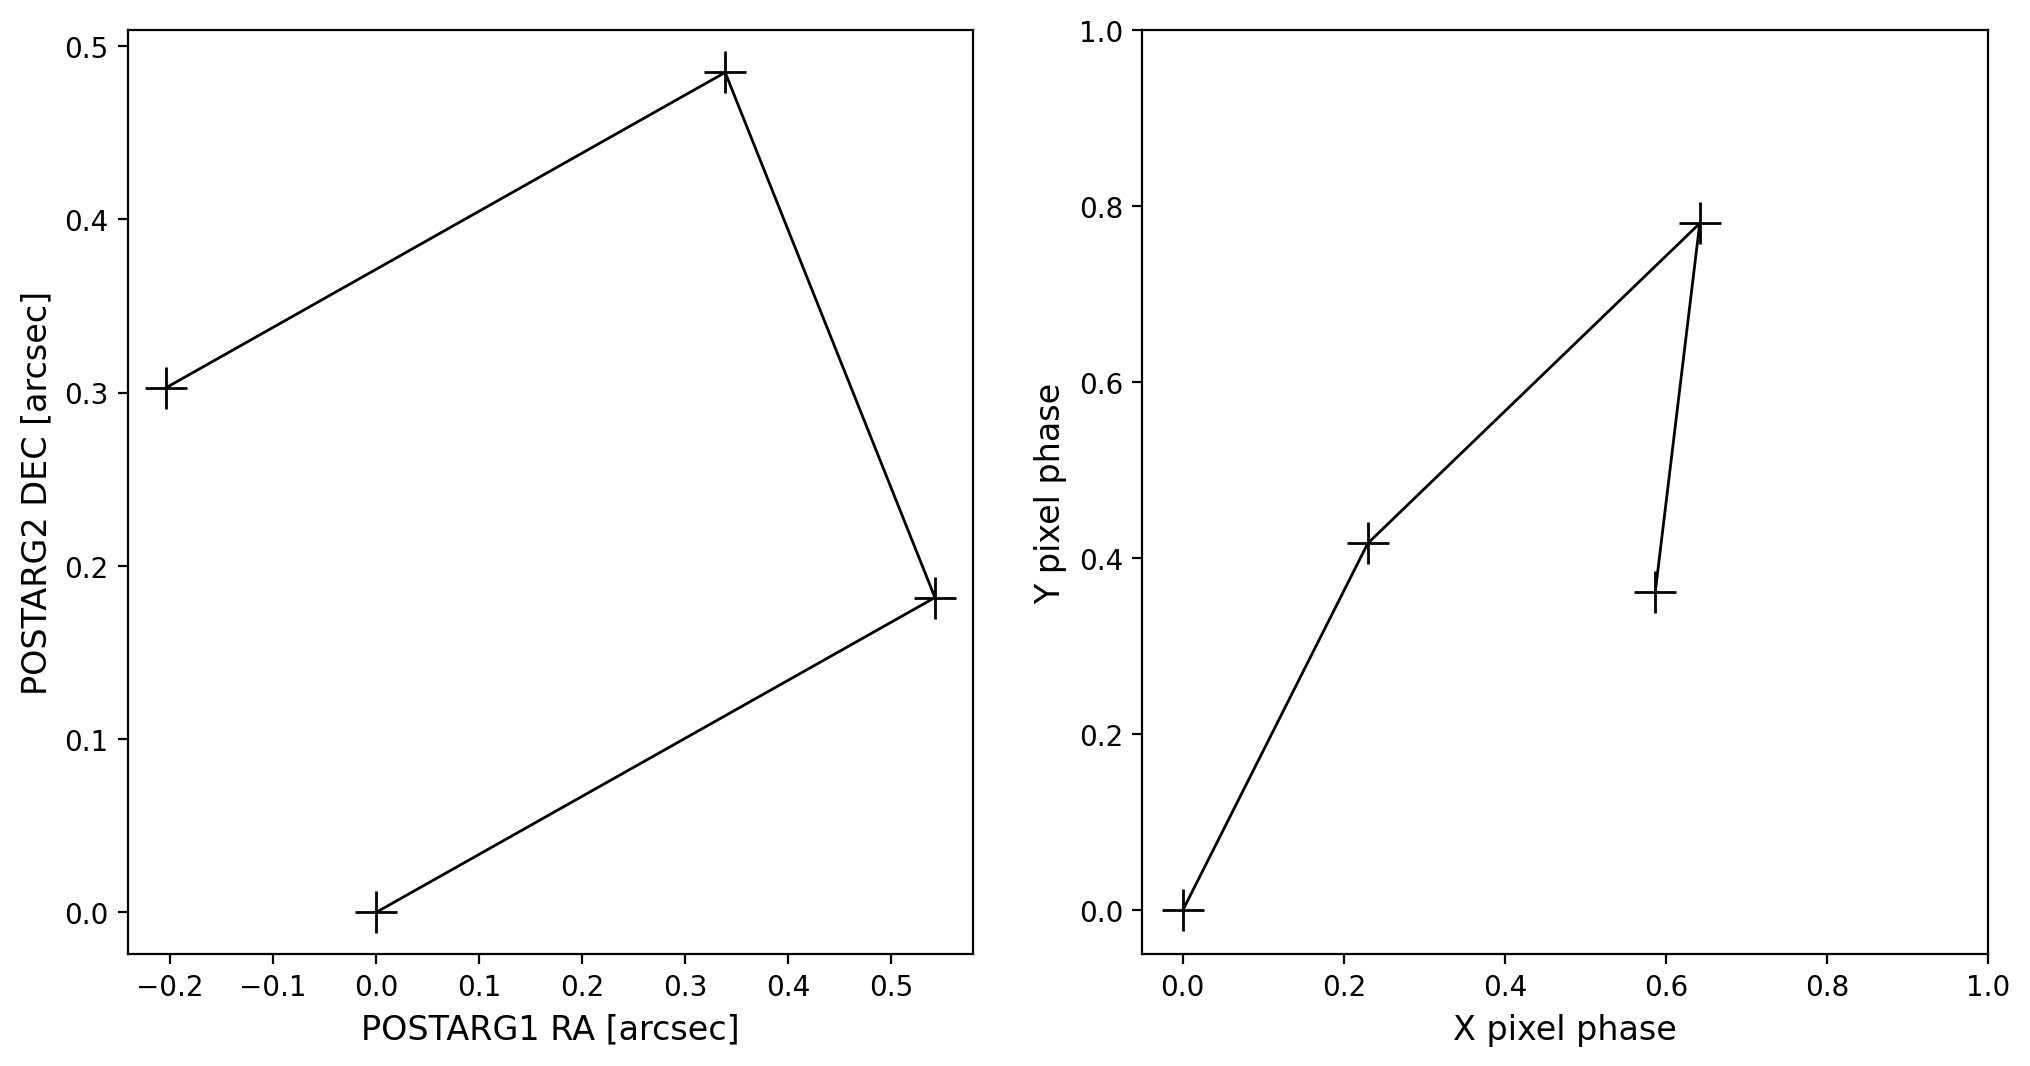

In [5]:
plate_scale = fits.getval(flt_files[0], 'idcscale', ext=1)
print('Detector Plate scale: {:>6.4f}'.format(plate_scale))
postarg1 = np.empty(len(flt_files), dtype=np.float16)
postarg2 = np.empty(len(flt_files), dtype=np.float16)
x_phase = np.empty(len(flt_files), dtype=np.float16)
y_phase = np.empty(len(flt_files), dtype=np.float16)

for i, im in enumerate(flt_files):
    with fits.open(im) as hdu:
        postarg1[i] = hdu[0].header['postarg1']
        postarg2[i] = hdu[0].header['postarg2']
        x_phase[i] = abs(np.modf(postarg1[i] / plate_scale)[0])
        y_phase[i] = abs(np.modf(postarg2[i] / plate_scale)[0])
        
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].plot(postarg1, postarg2, 'k+-', ms=15, lw=1)
ax[0].set_xlabel('POSTARG1 RA [arcsec]', fontsize='large')
ax[0].set_ylabel('POSTARG2 DEC [arcsec]', fontsize='large')

ax[1].plot(x_phase, y_phase, 'k+-', ms=15, lw=1)
ax[1].set_xlim(-0.05, 1)
ax[1].set_ylim(-0.05, 1)
ax[1].set_xlabel('X pixel phase', fontsize='large')
ax[1].set_ylabel('Y pixel phase', fontsize='large')

<a id="inspect_wcs"></a>
### 2.3 Inspect the alignment 

Check the active WCS solution in the image header. If the image is aligned to a catalog, list the number of matches and the fit RMS in mas. <br> 
Convert the fit RMS values to pixels for comparison with the alignment results performed later in this notebook.

In [6]:
ext_0_kws = ['DETECTOR', 'EXPTIME']
ext_1_kws = ['WCSNAME', 'NMATCHES', 'RMS_RA', 'RMS_DEC']

det_scale = {'IR': 0.1283, 'UVIS': 0.0396, 'WFC': 0.05}                    # plate scale (arcsec/pixel)

format_dict = {}
col_dict = defaultdict(list)

for f in flt_files:
    col_dict['filename'].append(f)
    hdr0 = fits.getheader(f, 0)
    hdr1 = fits.getheader(f, 1)
    
    for kw in ext_0_kws:                                                # extension 0 keywords
        col_dict[kw].append(hdr0[kw])
    for kw in ext_1_kws:                                                # extension 1 keywords
        if 'RMS' in kw:
            val = np.around(hdr1[kw], 1)
        else: 
            val = hdr1[kw]
        col_dict[kw].append(val)
        
    for kw in ['RMS_RA', 'RMS_DEC']:
        val = np.round(hdr1[kw]/1000./det_scale[hdr0['DETECTOR']], 2)  # convert RMS from mas to pixels
        col_dict[f'{kw}_pix'].append(val)

wcstable = Table(col_dict)
wcstable

filename,DETECTOR,EXPTIME,WCSNAME,NMATCHES,RMS_RA,RMS_DEC,RMS_RA_pix,RMS_DEC_pix
str18,str2,float64,str28,int64,float64,float64,float64,float64
ib1f19l6q_flt.fits,IR,502.936462,IDC_w3m18525i-FIT_REL_GSC242,23,104.6,103.6,0.82,0.81
ib1f19l7q_flt.fits,IR,502.936462,IDC_w3m18525i-FIT_REL_GSC242,23,104.6,103.6,0.82,0.81
ib1f19l9q_flt.fits,IR,502.936462,IDC_w3m18525i-FIT_REL_GSC242,23,104.6,103.6,0.82,0.81
ib1f19laq_flt.fits,IR,502.936462,IDC_w3m18525i-FIT_REL_GSC242,23,104.6,103.6,0.82,0.81


Here we see that the four FLC images have a "FIT_REL_GSC242" WCS solution, which means they were aligned as a set to the reference catalog 'GSC v2.4.2' using the drizzled-combined (DRC) image, and that WCS was propogated back to the original FLCs.  This is reflected in the fact that the number of matches and fit rms values are the same for each FLC frame.  

For more details on absolute astrometry in HST images, see [Section 4.5 in the DrizzlePac Handbook](https://hst-docs.stsci.edu/drizzpac/chapter-4-astrometric-information-in-the-header/4-5-absolute-astrometry)

Since the relative alignment of the individual FLC frames is preserved, we do not need run `TweakReg` before drizzling the images.

<a id="drizzle"></a>
## 3. Drizzling 
[Table of Contents](#toc)

Before drizzling can be performed, a plate scale for the output image should be chosen. This will usually be dictated by the science needs. In theory, critical sampling of a PSF occurs with 2.355 pixels. The FWHM of the WFC3/IR detector at 1600 nm is ~0.151" (Table 7.5 of [WFC Instrument Handbook](https://hst-docs.stsci.edu/wfc3ihb/chapter-7-ir-imaging-with-wfc3/7-6-ir-optical-performance)). Using these values, a plate scale of 0.065"/pix will be selected for the drizzled output frame, approximately half of the native plate scale (0.1283"/pix). 

The mechanism by which the *drizzle* algorithm improves sampling in the output image is by shrinking the input pixels before adding them to the output pixel grid (see Figure 2 in [Fruchter and Hook (2002)](http://iopscience.iop.org/article/10.1086/338393/pdf)). In practice this process is controlled in the `AstroDrizzle` package by adjusting the `final_pixfrac` parameter, which is the fractional size of the pixel to be used. 
Below `AstroDrizzle` is called twice. The first time, no changes are made to the plate scale or the size of the drop. In the second call, the plate scale and pixfrac are reduced. For a four point dither stack, a `final_pixfrac` value of 0.8 is usually optimal.

Next, we get some recommended values for drizzling from the MDRIZTAB reference file.  The parameters in this file are different for each detector and are based on the number of input frames. These are a good starting point for drizzling and may be adjusted accordingly.

To see the full list of `AstroDrizzle` parameters, consult the [DrizzlePac readthedocs](https://drizzlepac.readthedocs.io/en/latest/drizzlepac_api/astrodrizzle.html) page. 

In [7]:
mdz = fits.getval(flt_files[0], 'MDRIZTAB', ext=0).split('$')[1]
print('Searching for the MDRIZTAB file:', mdz)
!crds sync --hst --files {mdz} --output-dir {os.environ['iref']}

Searching for the MDRIZTAB file: 3562021pi_mdz.fits


CRDS - INFO -  Symbolic context 'hst-latest' resolves to 'hst_1197.pmap'
CRDS - INFO -  Reorganizing 0 references from 'instrument' to 'flat'
CRDS - INFO -  Reorganizing from 'instrument' to 'flat' cache,  removing instrument directories.
CRDS - INFO -  Syncing explicitly listed files.


CRDS - INFO -  Fetching  ./crds_cache/references/hst/wfc3/3562021pi_mdz.fits       40.3 K bytes  (1 / 1 files) (0 / 40.3 K bytes)


CRDS - INFO -  0 errors
CRDS - INFO -  0 warnings
CRDS - INFO -  5 infos


In [8]:
def get_vals_from_mdriztab(input_images, kw_list=['driz_sep_bits', 
                                                  'combine_type', 
                                                  'driz_cr_snr', 
                                                  'driz_cr_scale', 
                                                  'final_bits']):
    
    '''Get only selected parameters from. the MDRIZTAB'''
    mdriz_dict = drizzlepac.processInput.getMdriztabPars(input_images)
    
    requested_params = {}
    
    print('Outputting the following parameters:')
    for k in kw_list:
        requested_params[k] = mdriz_dict[k]
        print(k, mdriz_dict[k])
    
    return requested_params

In [9]:
selected_params = get_vals_from_mdriztab(flt_files)

- MDRIZTAB: AstroDrizzle parameters read from row 3.
Outputting the following parameters:
driz_sep_bits 528
combine_type median
driz_cr_snr 5.0 4.0
driz_cr_scale 3.0 2.4
final_bits 528


In this example, we have turned off the four `AstroDrizzle` steps used for performing CR-rejection. For WFC3/IR frames this is done in the up-the-ramp fitting in `calwf3`.  If desired, the CR-rejection may be turned on if the user wishes to further the flagging of bad pixels. 

In [10]:
drizzlepac.astrodrizzle.AstroDrizzle(flt_files,
                                     output='f160w_noopt',
                                     context=False, build=True, preserve=False,
                                     **selected_params,
                                     skymethod='match',
                                     driz_separate=False, median=False, blot=False, driz_cr=False, # CR-rej off
                                     final_wcs=True,
                                     final_rot=0.,
                                     final_scale=None)

drizzlepac.astrodrizzle.AstroDrizzle(flt_files,
                                     output='f160w_opt',
                                     context=False, build=True, preserve=False,
                                     **selected_params,
                                     skymethod='match',
                                     driz_separate=False, median=False, blot=False, driz_cr=False, # CR-rej off
                                     final_wcs=True,
                                     final_rot=0.,
                                     final_scale=0.065,
                                     final_pixfrac=0.8)

clear_output()    

<a id="results"></a>
## 4. Results 
[Table of Contents](#toc)

The drizzled science and weight images produced from the first call to AstroDrizzle with no optimization of the plate scale and pixfrac are plotted below. 

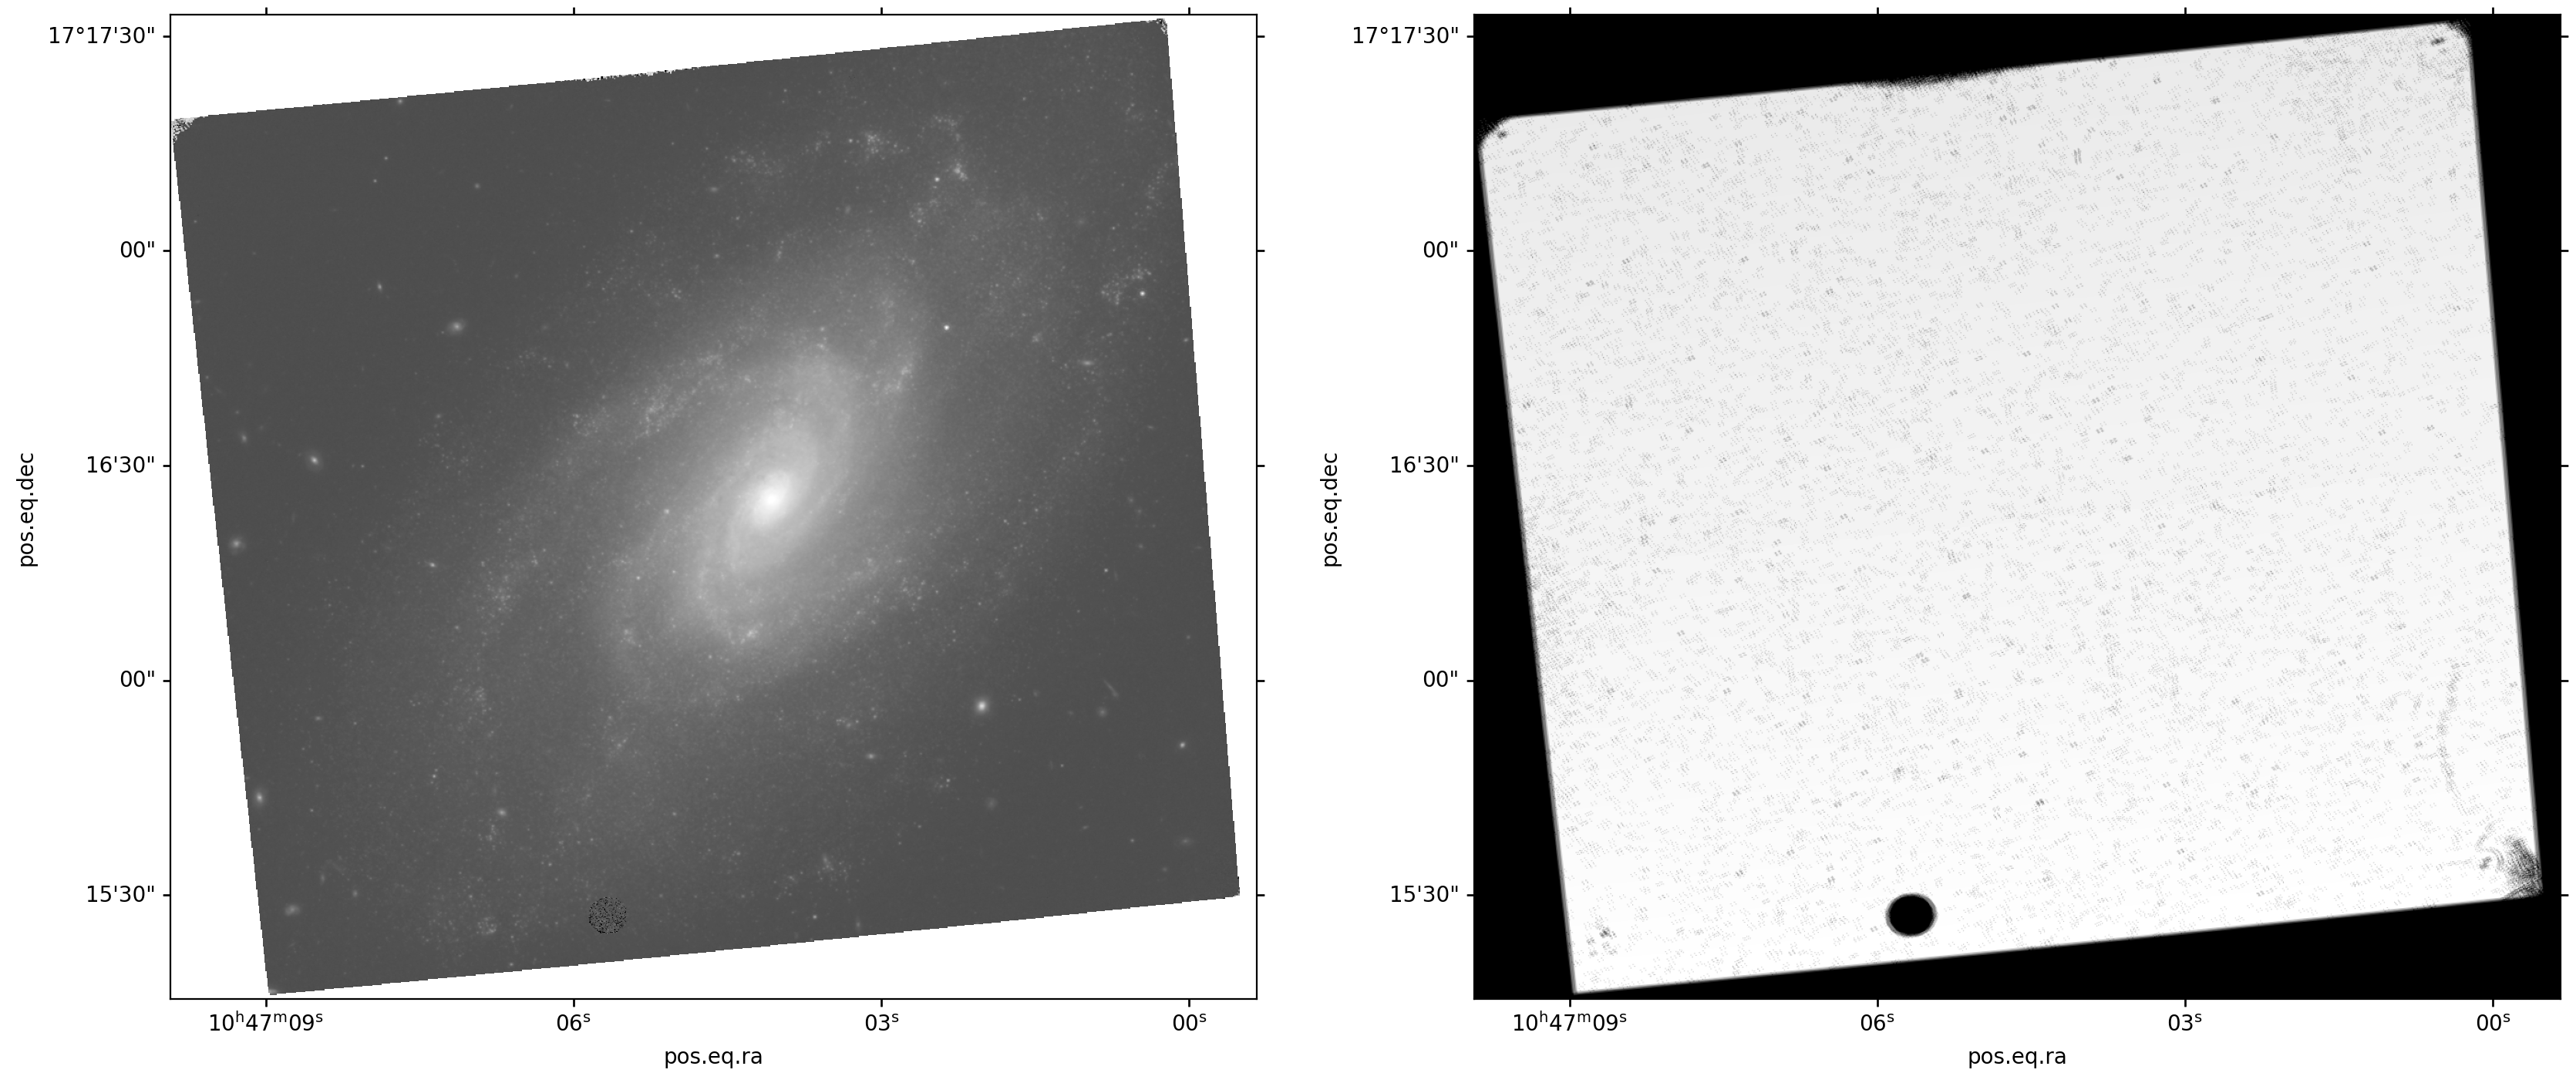

In [11]:
with fits.open('f160w_noopt_drz.fits') as hdu:
    im1wcs = wcs.WCS(hdu[1].header)
    sci1 = hdu[1].data
    wht1 = hdu[2].data
        
norm1 = ImageNormalize(sci1, vmin=-0.05, vmax=100, stretch=LogStretch())
fig, ax = plt.subplots(1, 2, figsize=(20, 15), subplot_kw={'projection': im1wcs})
ax[0].imshow(sci1, norm=norm1, cmap='gray', origin='lower')
ax[1].imshow(wht1, cmap='gray', origin='lower')

The drizzled science image is on the left and the associated weight image is on the right, both without optimization of the plate scale and pixfrac.

To compare, the figure plotted below shows close ups of the same part of the sky from the two drizzled products. 

(1835.4481178798214, 1934.1019662351332)

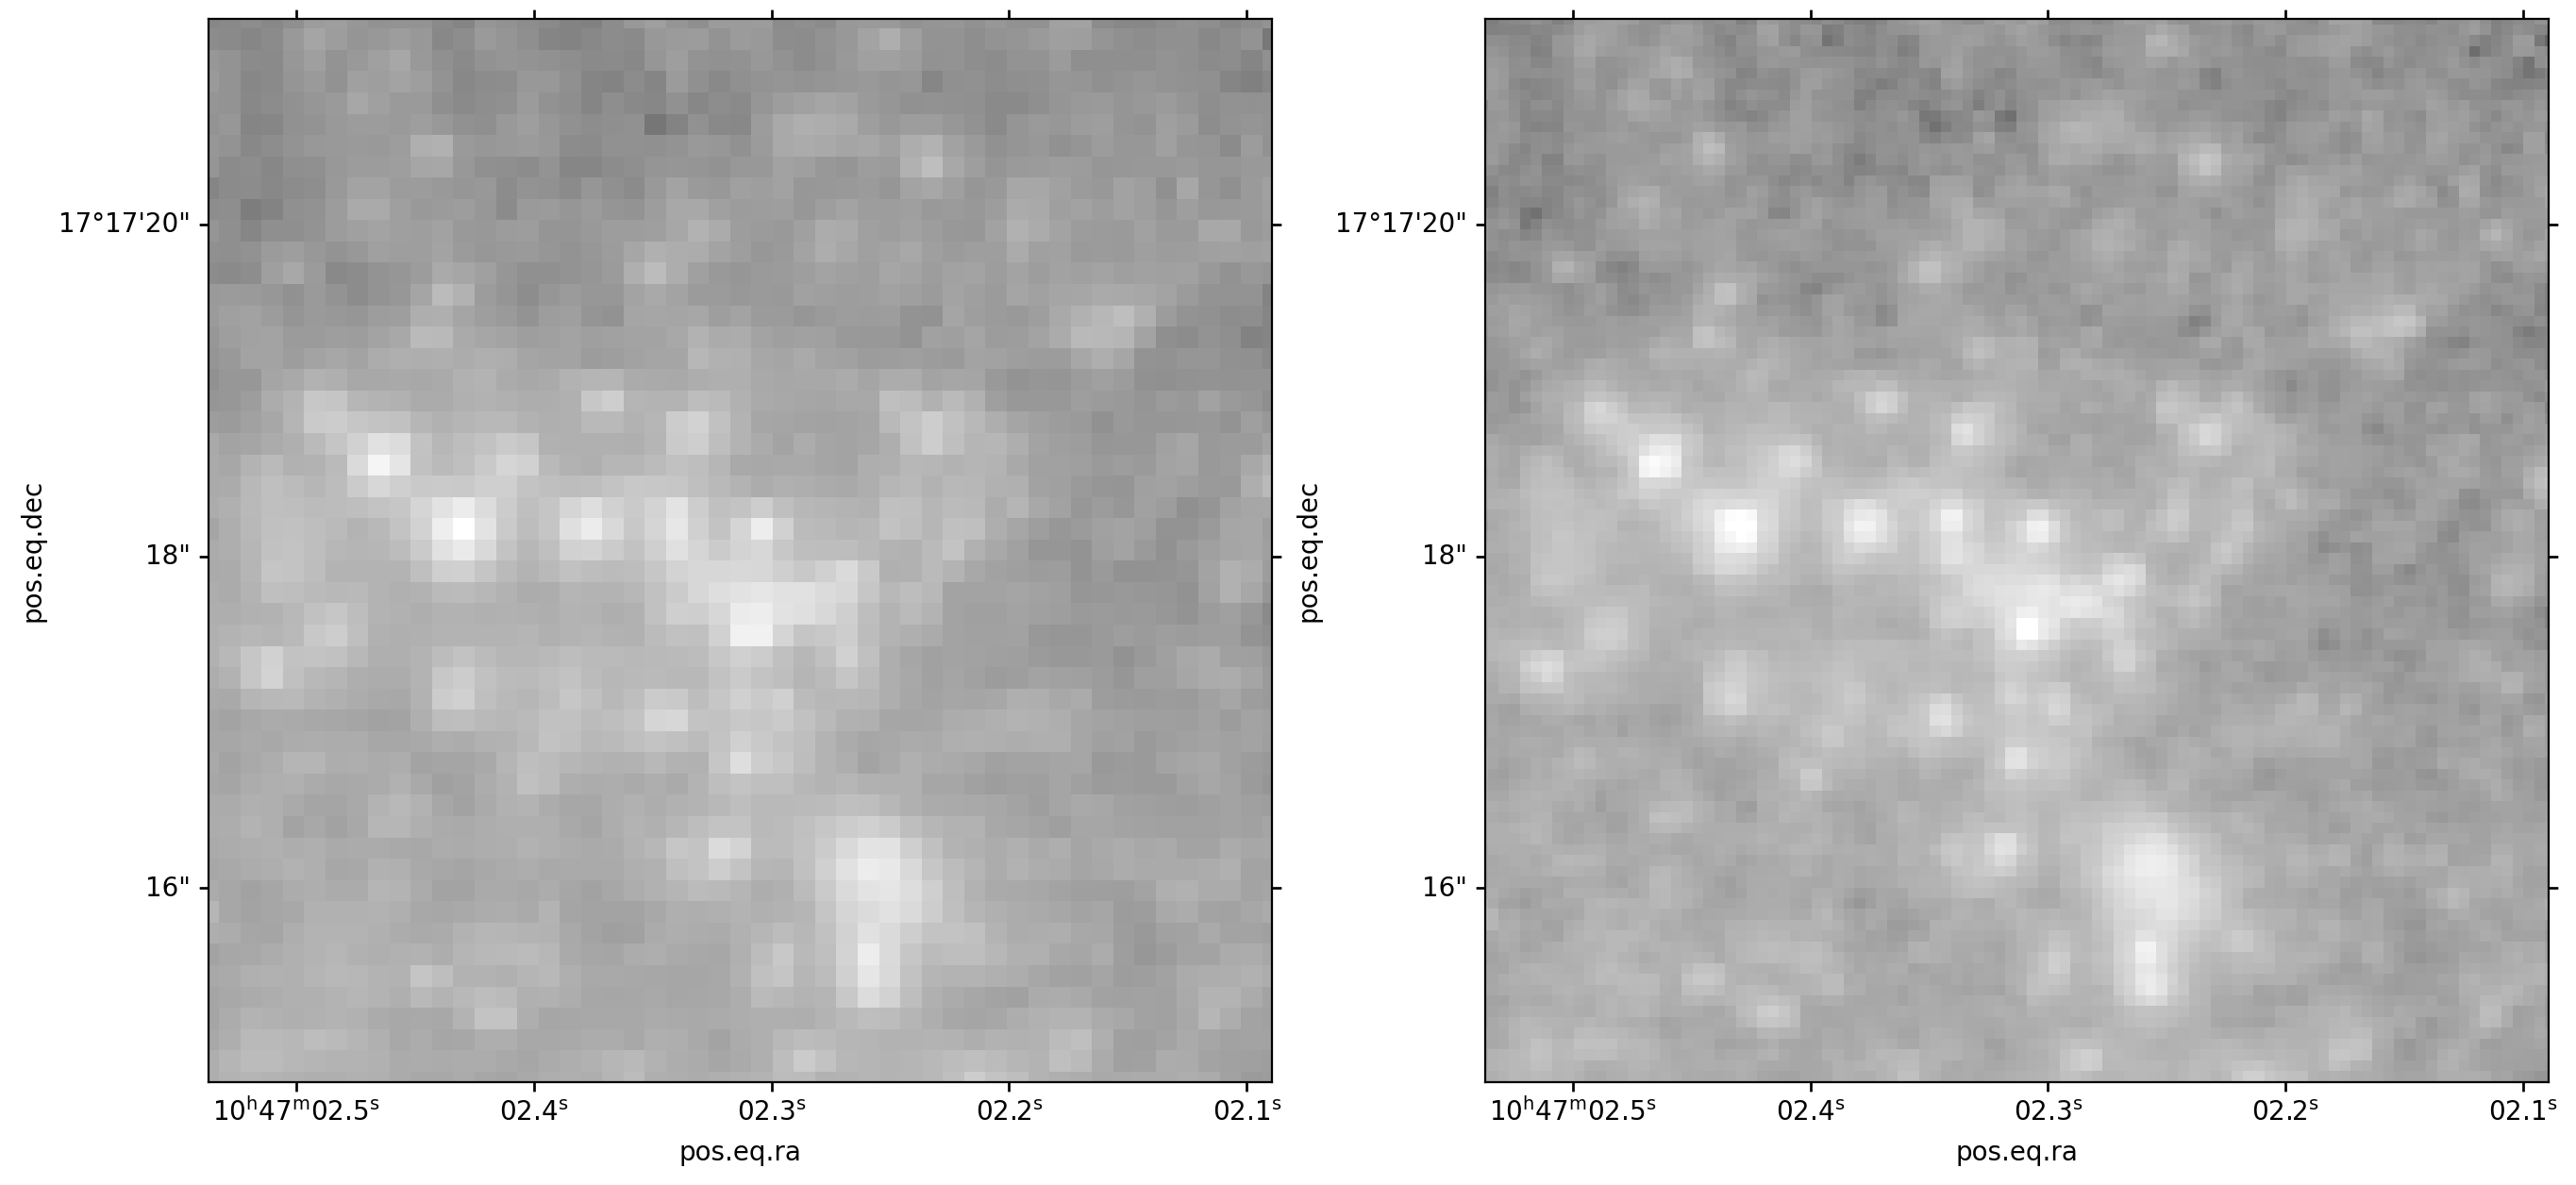

In [12]:
radeclims = wcs.utils.pixel_to_skycoord([825, 875], [930, 980], im1wcs)

with fits.open('f160w_opt_drz.fits') as hdu:
    im2wcs = wcs.WCS(hdu[1].header)
    sci2 = hdu[1].data
    wht2 = hdu[2].data

norm1 = ImageNormalize(sci2, vmin=0.70, vmax=4.0, stretch=LogStretch())
norm2 = ImageNormalize(sci2, vmin=0.18, vmax=1.0, stretch=LogStretch())
    
fig = plt.figure(figsize=(16, 8))

ax = fig.add_subplot(1, 2, 1, projection=im1wcs)
ax.imshow(sci1, norm=norm1, cmap='gray')
ax.set_xlim(radeclims.to_pixel(im1wcs)[0])
ax.set_ylim(radeclims.to_pixel(im1wcs)[1])

ax = fig.add_subplot(1, 2, 2, projection=im2wcs)
ax.imshow(sci2, norm=norm2, cmap='gray')
ax.set_xlim(radeclims.to_pixel(im2wcs)[0])
ax.set_ylim(radeclims.to_pixel(im2wcs)[1])                  

The image on the left is without improved plate scale and pixfrac, and shows that the detector undersamples the PSF. The image on the right is the image with optimized parameters where the resolution is greatly improved. 

<a id="pixfrac"></a>
## 5. Optimizing the `final_pixfrac` parameter 
[Table of Contents](#toc)

While the optimized `final_pixfrac` in the example above was chosen from experience with using a four-point dither, the value that should be used is not known *a priori*. The value could be different depending on several factors. For example, if the number of images is greater than four, the value used for `final_pixfrac` could be smaller since more images are available to fill in holes in the output grid. On the other hand, it is possible that no dithering was used during the observations. In that case, `final_pixfrac` should be left at 1.0, since shrinking the size of the drop could be detrimental. 

Below, a series of experiments will be run to determine the best `final_pixfrac` value for the selected output plate scale, by varying pixfrac in steps of 0.1 over a range of values from 0.1 to 1.0.

<div class="alert alert-block alert-warning" style="color:black" >  This cell may take a few minutes to execute. </div>

In [13]:
pixfracs = np.arange(0.1, 1.1, 0.1)

for pixfrac in pixfracs:
    outname = 'f160w_{:.1f}'.format(pixfrac)
    drizzlepac.astrodrizzle.AstroDrizzle(flt_files,
                                         output=outname,
                                         **selected_params,
                                         context=False, build=True, preserve=False,      
                                         skymethod='match',
                                         driz_separate=False, median=False, blot=False, driz_cr=False,
                                         final_pixfrac=pixfrac,
                                         final_wcs=True,
                                         final_rot=0.,
                                         final_scale=0.065)
clear_output()    

When evaluating what value to use for `final_pixfrac`, *THERE IS NO SINGLE METRIC THAT INDICATES WHAT VALUE TO USE*, and several factors should be taken into account. The general philosophy is that the chosen value should improve the resolution of the image as much as possible, without causing any adverse effects. 

The first thing to look for is an excessive number of holes in the science and weight images. The figure below shows the central region of the science and weight images produced by three different `final_pixfrac` values.

(1835.4481178798214, 1934.1019662351332)

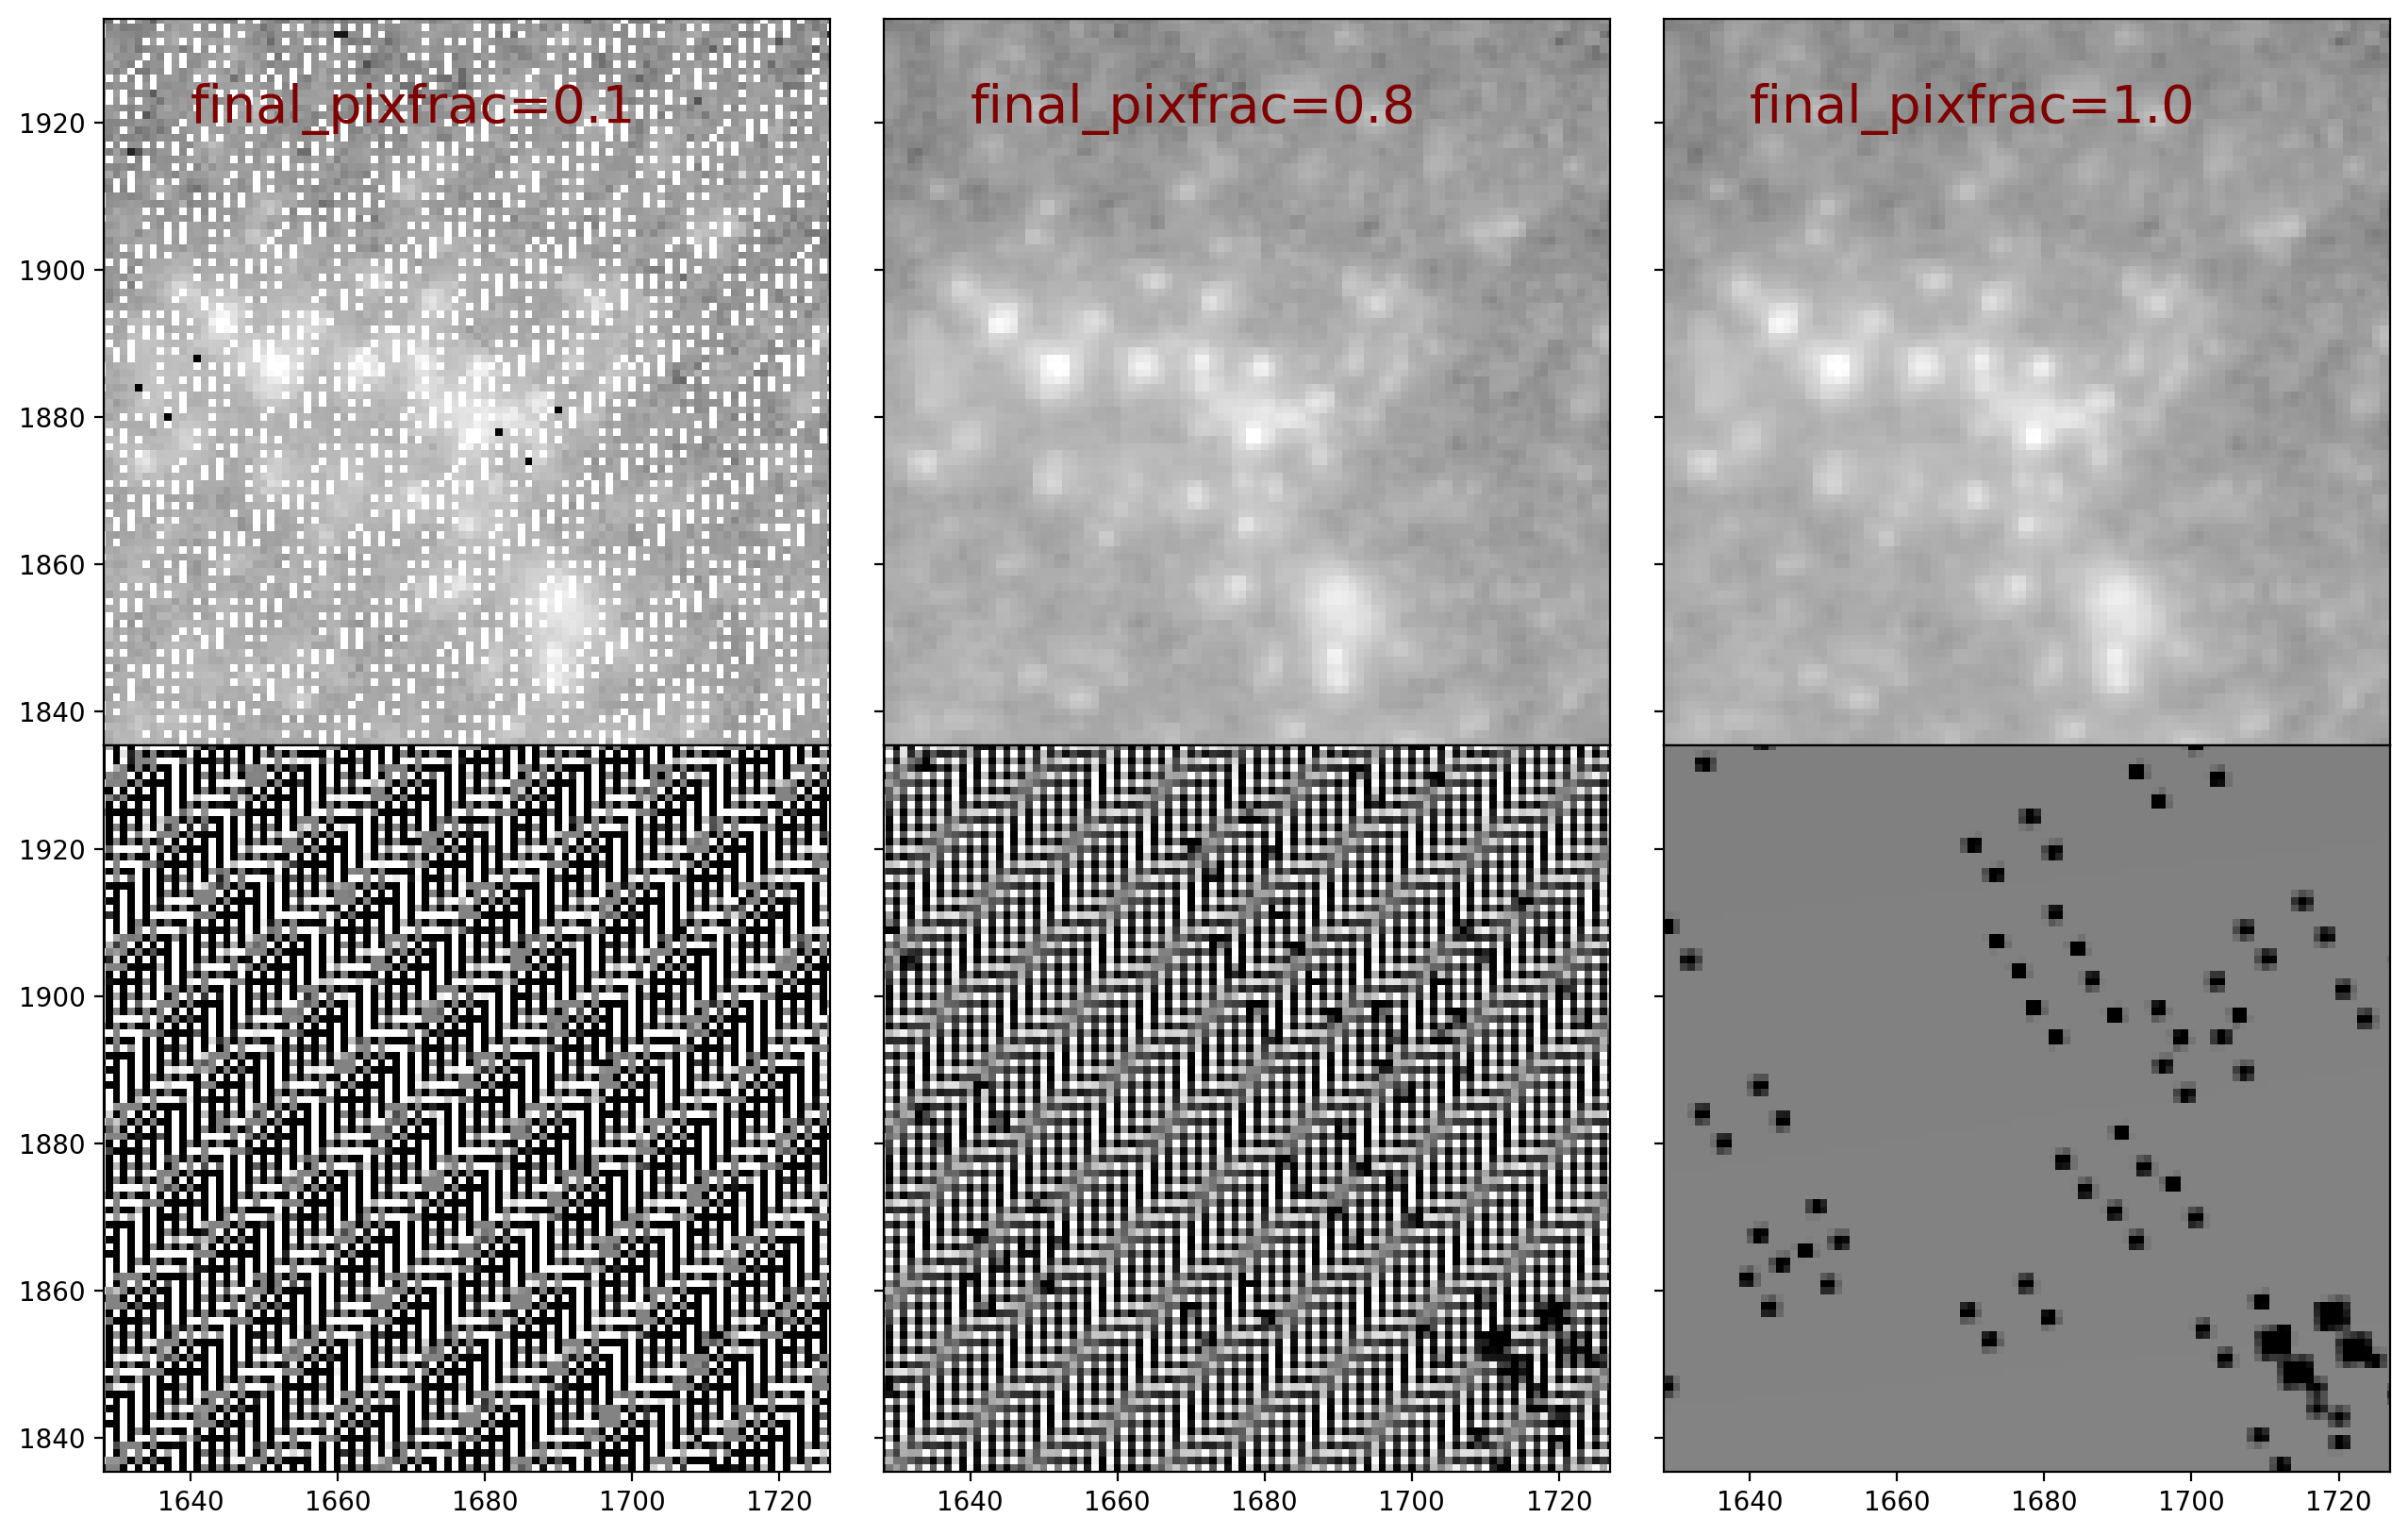

In [14]:
with fits.open('f160w_0.1_drz.fits') as hdu1:
    sci1 = hdu1[1].data
    wht1 = hdu1[2].data
    
with fits.open('f160w_0.8_drz.fits') as hdu2:
    sci2 = hdu2[1].data
    wht2 = hdu2[2].data
    
with fits.open('f160w_1.0_drz.fits') as hdu3:
    sci3 = hdu3[1].data
    wht3 = hdu3[2].data

fig, ax = plt.subplots(2, 3, figsize=(16, 10), sharex=True, sharey=True)
fig.subplots_adjust(hspace=0, wspace=0)

norm3 = ImageNormalize(wht2, vmin=400, vmax=600, stretch=LinearStretch())
ax[0, 0].imshow(sci1, norm=norm2, cmap='gray')
ax[0, 0].text(1640, 1920, 'final_pixfrac=0.1', fontsize='20', color='maroon')
ax[0, 1].imshow(sci2, norm=norm2, cmap='gray')
ax[0, 1].text(1640, 1920, 'final_pixfrac=0.8', fontsize='20', color='maroon')
ax[0, 2].imshow(sci3, norm=norm2, cmap='gray')
ax[0, 2].text(1640, 1920, 'final_pixfrac=1.0', fontsize='20', color='maroon')
ax[1, 0].imshow(wht1, norm=norm3, cmap='gray')
ax[1, 1].imshow(wht2, norm=norm3, cmap='gray')
ax[1, 2].imshow(wht3, norm=norm3, cmap='gray')
ax[0, 0].set_xlim(radeclims.to_pixel(im2wcs)[0])
ax[0, 0].set_ylim(radeclims.to_pixel(im2wcs)[1])

This figure above shows the central region of the science and weight images produced by `final_pixfrac` values (left to right) of 0.1, 0.8 and 1.0. The top row is the science frame, the bottom is the weight image. The science image with the smallest `final_pixfrac` value of 0.1 shows a noisy background and holes in the image where no input pixels fall into the output grid because pixfrac is too small. Inspection of the weight map corresponding to the smallest `final_pixfrac` value shows many places with weights of zero, indicating that a `final_pixfrac` value of 0.1 is clearly too small and was only included in this example for illustrative purposes.

Another piece of information that can be useful is the amount of noise in the weight image. As suggested in the [DrizzlePac Handbook](https://hst-docs.stsci.edu/drizzpac/chapter-7-data-quality-checks-and-trouble-shooting-problems/7-3-inspecting-drizzled-products-after-user-reprocessing) Section 7.3, statistics performed on the drizzled weight image should yield a RMS/median value less than ~0.2. This threshold controls the trade-off between improving image resolution versus increasing background noise due to pixel resampling.
 
The figure below shows the RMS/median as a function of `final_pixfrac`. One should take care to use the same region in the weight image as the region where the object of interest is located in the science image. If one is using the entire image for scientific analysis, then one should measure the statistics of the weight image where there is more variance. 

Text(1.0, 0.75, '4 images')

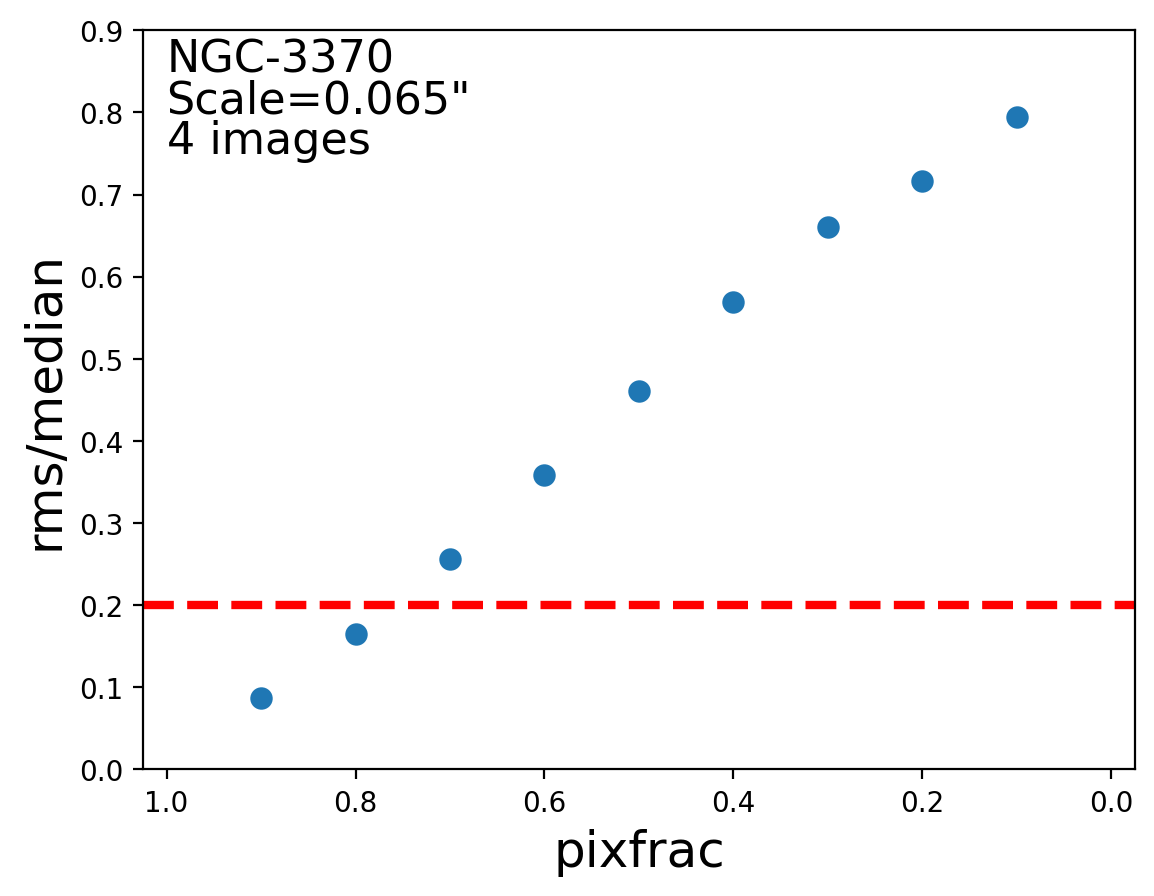

In [15]:
whtlist = glob.glob('f160w_0.[0-9]*drz.fits')

std_med = np.empty(len(whtlist), dtype=float)
fraclist = np.empty(len(whtlist), dtype=float)
xlims = radeclims.to_pixel(im1wcs)[0].astype(int)
ylims = radeclims.to_pixel(im1wcs)[1].astype(int)

# Loop that measures statistics, also some information gathering
for i, im in enumerate(whtlist):
    with fits.open(im) as hdu:
        hdr = hdu[0].header
        wht = hdu[2].data
    if i == 0:
        target = hdr['TARGNAME']
        scale = str(hdr['D001SCAL'])
        nimg = hdr['NDRIZIM']
    wht_std = np.std(wht[ylims[0]: ylims[1], xlims[0]: xlims[1]])
    wht_med = np.median(wht[ylims[0]: ylims[1], xlims[0]: xlims[1]])
    std_med[i] = wht_std / wht_med
    fraclist[i] = hdr['D001PIXF']

# Plotting commands              
plt.clf()
plt.xlim(1.025, -0.025)
plt.ylim(0., 0.9)
plt.scatter(fraclist, std_med, s=50)
plt.axhline(0.2, ls='--', lw=3, c='r')
plt.xlabel('pixfrac', fontsize=18)
plt.ylabel('rms/median', fontsize=18)
plt.text(1.0, 0.85, target, fontsize=16, horizontalalignment='left')
plt.text(1.0, 0.80, 'Scale=' + str(scale) + '"', fontsize=16, horizontalalignment='left')
plt.text(1.0, 0.75, str(nimg) + ' images', fontsize=16, horizontalalignment='left')

The RMS/median increases steadily down to `final_pixfrac` value of 0.3, where there is a change in the slope of the function, indicating that something odd might be happening beyond that point. The RMS remains below 20% of the median all the way down to `final_pixfrac` of 0.8, but the science and weight images should be inspected at all values to ensure no quality degradation has occurred. 

<a id="final"></a>
## 6. Final thoughts 
[Table of Contents](#toc)

The `final_pixfrac` value has to be small enough to avoid degrading the combined output image, but large enough that when all images are "dropped" onto the final frame, coverage of the output frame is fairly uniform. In general, `final_pixfrac` should be slightly larger than the final output scale to allow some "spillover" to adjacent pixels. This will help avoid "holes" in the final product when a given pixel has been flagged as "bad" in several frames. As a rule of thumb, statistics performed on the drizzled weight image in the region of interest should yield an RMS value (standard deviation) that is less than 20% of the median value. This threshold is a balance between the benefits of improving the image resolution at the expense of increasing noise in the background.

<a id="about"></a>
## About this Notebook

    Created: 12 Dec 2018;     R. Avila
    Updated: 29 Apr 2024;     R. Avila & J. Mack

**Source:** GitHub [spacetelescope/hst_notebooks](https://github.com/spacetelescope/hst_notebooks)

<a id="add"></a>
## Additional Resources

Below are some additional resources that may be helpful. Please send any questions through the [HST Help Desk](https://stsci.service-now.com/hst).

- [WFC3 Website](https://www.stsci.edu/hst/instrumentation/wfc3)
- [ACS Website](https://www.stsci.edu/hst/instrumentation/acs)
- [WFC3 Instrument Handbook](https://hst-docs.stsci.edu/wfc3ihb)
- [WFC3 Data Handbook](https://hst-docs.stsci.edu/wfc3dhb)
- [Drizzlepac Handbook](https://hst-docs.stsci.edu/drizzpac)
- [Astrodrizzle keywords documentation](https://drizzlepac.readthedocs.io/en/latest/drizzlepac_api/astrodrizzle.html)

<a id="cite"></a>
## Citations
If you use Python packages such as `astropy`, `astroquery`, `drizzlepac`, `matplotlib`, or `numpy` for published research, please cite the authors.

Follow these links for more information about citing various packages:

* [Citing `astropy`](https://www.astropy.org/acknowledging.html)
* [Citing `astroquery`](https://github.com/astropy/astroquery/blob/main/astroquery/CITATION)
* [Citing `drizzlepac`](https://zenodo.org/records/3743274)
* [Citing `matplotlib`](https://matplotlib.org/stable/users/project/citing.html)
* [Citing `numpy`](https://numpy.org/citing-numpy/)
***

[Top of Page](#top)